<h1 style="text-align:center;">Nuc Adder <span style="text-align:center;font-size: 0.5em;">1.5.1</span></h1>
<h2 style="text-align:center;">Mito Hacker Toolkit <i style="font-size: 0.5em;">0.7.1</i></h2>
<h3 style="text-align:center;">Kashatus Lab @ UVA</h3>

# Welcome to Nuc Adder
#### Nuc Adder is part of Mito Hacker toolkit that enables you to make images that are missing nuclei staining compatible with CeMiA Cell Catcher and Mito Miner.
This Jupyter notebook provides you with step-by-step directions to transform your images.

## 1) Importing necessary libraries
Please check the requirements in the Readme file.

In [3]:
#Base
import os
import cv2
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
import random
from pprint import pprint

#Interaction
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact, interactive, fixed, interact_manual, IntSlider, Checkbox, FloatSlider, Dropdown
from IPython.display import clear_output

#Core Functions
import cemia55s as cemia

layout = widgets.Layout(width='800px')

## 2) Locate and Sample Files

<br>
<details>
<summary><span style="font-size:16px;font-weight: bold; color:red">Instructions</span></summary>


#### <span style="color:red;">Interact with the code: </span> Please enter the relative address of the folder that contains your images. 

#### <span style="color:red;">You should interact with the next cell: </span> Please run the next cell, a box will appear. Enter the relative/absolute address of the folder that contains your images inside the box, then press enter. 


#### <span style="color:red;">Examples: </span>
* Use . if the images are in the same folder as this file
* If the folder of the images is named "test" and is located on the upper level of the current folder, the address would be ../test (Mac)

#### <span style="color:red;">Note: </span>
* It is preferred to have the folder of your images in the same folder as the current file that you are running
* After you enetered the address to your files in the box, you should press enter key.

</details>

In [4]:
address,file_list = cemia.address()

Where are the files located?

C:\Users\Nabiki\Desktop\development\segmentation_models_comparison_system\inputs\aag_dataset_aag_masks_nadh_1_to_10_no_suffix\images\nuc_adder test images

All set! You may run the next cell.


In [6]:
cleaned_list = cemia.random_files(address,file_list,len(file_list))
# pprint(cleaned_list)

cemia.nuc_adder_make_folders(address)


These files were validated and selected:

 ['2020_10_21_HeLa_nadh_fov_0001-image.tiff', '2020_10_21_HeLa_nadh_fov_0002-image.tiff']


## 3) Adjusting The Nuclei Size

#### Cell Catcher and Mito Miner need nuclei boundary to assess the out-of-plane signal (Background Intensity).  Apparently, nuclei staining is missing from your images, and that's why you are here!

#### First things first! Let's  find a proper nuclei size for your set of images.
<br>
<details>
<summary><span style="font-size:16px;font-weight: bold; color:red">Instructions</span></summary>


#### <span style="color:red;">Interaction Required: </span>
* Identify a proper nuclei size (as if the nuclei were stained in your images) for your set of images by adjusting the handle.
* You can move the simulated nucleus on the image. to ensure proper sizing. (The location has no effect of future analysis, and is for visualization purposes only.

#### <span style="color:red;">Note: </span>
* We suggest to be a bit conservative with your size choice. Large nuclei sizes, may cause overlap with the actual mitochondrial network, and result in inaccurate background estimations.
* The circle size should be large enough to sample enough background pixels, and small enough to not have an overlap with mitochondrial network accross different cells

</details>

In [7]:
size = plt.imread(os.path.join(address,cleaned_list[0])).shape
radii = []

@interact(file=cleaned_list, radius=IntSlider(min=25,max=100,step=5,value=10,continuous_update=False,layout=layout),
         x=IntSlider(min=100,max=size[0]-100,step=10,value=150,continuous_update=False,layout=layout),
         y=IntSlider(min=100,max=size[0]-100,step=10,value=150,continuous_update=False,layout=layout),
         filled=Checkbox(value=True,description='Filled',layout = layout),)
          
def segment_nucleus(file, radius, x,y, filled):
    
    rad = cemia.simulate_circle(address, file, x,y,radius,filled)
    radii.append(rad)

interactive(children=(Dropdown(description='file', options=('2020_10_21_HeLa_nadh_fov_0001-image.tiff', '2020_…

## 4) Marking nuclei centers in your images

<br>
<details>
<summary><span style="font-size:16px;font-weight: bold; color:red">Instructions & Notes</span></summary>


### <span style="color:red;"><b>Interaction with an external window is required.</b> </span> 
#### 1) In this section, all the images in your target folder, will be displayed one-by-one.
#### 2) Once an image is displayed, an external window with the same image will open up.
#### 3) <span style="color:red;">Important: </span>On the external window, for each cell on the image, you have to <span style="color:red;">single click </span> (left click) on the point where you believe would be the center of the nucleus in that cell. Repeat this process for all the cells on the image.
#### 4) After you marked all the desired cell centers on the image, press "q" on the keyboard to go to the next image.
#### 5) Repeat this process for all the images in your target folder.
#### 6) Transformed images are saved in a sub directory names "transformed" in your target folder.

#### <span style="color:red;">Note: </span>
* Mac Users, may experince that the external window for the last image won't close properly after pressing "q". This is not an issue. After you press "q" for the last image, on the Jupyter notebook you will see the message "You are all set!", which indicates you are all set!
* Windows users will not experince this issue.

</details>

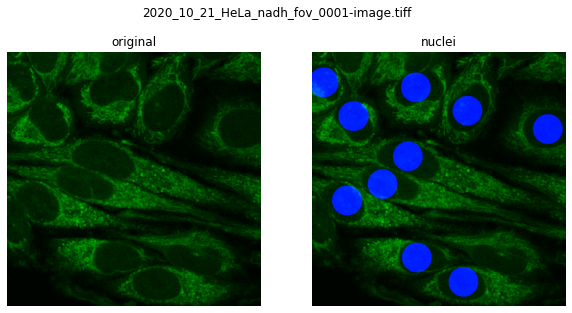

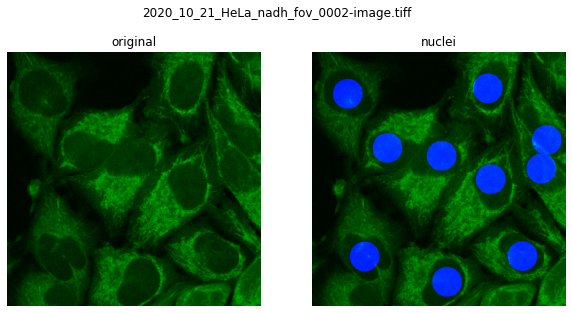


You are all set!

Your transformed images are saved at: "C:\Users\Nabiki\Desktop\development\segmentation_models_comparison_system\inputs\aag_dataset_aag_masks_nadh_1_to_10_no_suffix\images\nuc_adder test images/transformed/" and are eady to to be used by other tools at CeMiA.


In [13]:
roi_array = []

for image in cleaned_list:
    image_address = os.path.join(address,image)
    
    img1 = plt.imread(image_address,-1)
    img = deepcopy(img1)
    how_many = 1#cemia.how_many_cells()
    
    for i in range(how_many):
        drawing=False # true if mouse is pressed
        mode=True # if True, draw rectangle. Press 'm' to toggle to curve
        points = []
        roi_corners = []
        # mouse callback function
        def boundary(event,former_x,former_y,flags,param):
            global current_former_x,current_former_y,drawing, mode

            if event==cv2.EVENT_LBUTTONDOWN:
                drawing=True
                current_former_x,current_former_y=former_x,former_y
                points.append((current_former_x,current_former_y))
            elif event==cv2.EVENT_MOUSEMOVE:
                if drawing==True:
                    if mode==True:
                        cv2.line(img,(current_former_x,current_former_y),(former_x,former_y),(0,0,255),3)
                        current_former_x = former_x
                        current_former_y = former_y
                        points.append((current_former_x,current_former_y))

                        #print former_x,former_y
            elif event==cv2.EVENT_LBUTTONUP:
                drawing=False
                if mode==True:
                    ## ECG
                    cv2.circle(img, (current_former_x,current_former_y), radii[-1], color=(0,0,255), thickness=-1, lineType=8, shift=0)
                    ##
                    cv2.line(img,(current_former_x,current_former_y),(former_x,former_y),(0,0,255),3)
                    current_former_x = former_x
                    current_former_y = former_y
                    points.append((current_former_x,current_former_y))

            return former_x,former_y, points 

        cv2.namedWindow("Kashatus Lab",cv2.WINDOW_NORMAL)
        cv2.resizeWindow("Kashatus Lab",img.shape[0]//2,img.shape[1]//2)
        cv2.setMouseCallback('Kashatus Lab',boundary)
        while(1):
            cv2.imshow('Kashatus Lab',cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            if cv2.waitKey(1) & 0xFF == ord('q'):
                roi_corners = np.array(points, dtype=np.int32);
                roi_array.append(roi_corners)
                break

        cv2.waitKey(1)
        cv2.destroyAllWindows()
        cv2.waitKey(1)
        img_temp = deepcopy(img1)
        img = deepcopy(img1)
        # print(img.shape)
        for x,y in points:
            #print(f"radii: {radii[-1]}")
            cv2.circle(img_temp, (x,y), radii[-1], color=(0,0,255), thickness=-1, lineType=8, shift=0)
    img[:,:,2] = img_temp[:,:,2]
    
    ## plot figures
    fig, ax = plt.subplots(1,2, figsize=(10,5))
    fig.suptitle(f"{image}")
    ax[0].title.set_text("original")
    ax[0].set_axis_off()
    ax[0].imshow(img1)
    ax[1].title.set_text("nuclei")
    ax[1].set_axis_off()
    ax[1].imshow(img)
    plt.show()
    
    
    trans_file_name = image[:image.rfind('.')] + '_transformed' + image[image.rfind('.'):]
    output_address = os.path.join(address,'transformed', trans_file_name)
    cv2.imwrite(output_address,cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

print('\nYou are all set!')
print(f'\nYour transformed images are saved at: "{address}/transformed/" and are eady to to be used by other tools at CeMiA.')

# The End!